# Super-Resolution MRI Data Preprocessing

## 1. Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import cv2
import os

## 2. Managing Data

Define de forma aleatoria el Path de las imágenes a extraer

In [ ]:
# Define la ruta en donde se encuentren las imágenes MRI
path_files = r"C:\Users\Desktop\Datos\IDA\PPMI\3D\1.5 Tesla\Sagital"

In [ ]:
# Define la cantidad de estudios a extraer
num_mri = 333
files = os.listdir(path_files)
# Extrae los directorios de las imágenes en la ruta de entrada
files_dcm = []
for folder in files[:num_mri]:
    path_images = f'{path_files}\{folder}'
    # Lista de archivos DICOM
    images_dcm = [os.path.join(path_images, image) for image in os.listdir(path_images) if image.endswith('.dcm')]
    # Ordenar los archivos por el número de rebanada (Slice Number) para obtener el volumen correcto
    images_dcm.sort(key=lambda x: int(pydicom.dcmread(x).InstanceNumber))
    files_dcm.extend(images_dcm)
print("Cantidad de archivos DICOM:", len(files_dcm))

Cantidad de archivos DICOM: 55858


In [5]:
np.save('files_dcm.npy', files_dcm)

Carga del lote completo de imágenes

In [6]:
# Carga las imágenes originales de alta resolución de tamaño 256x256
images_mri = [pydicom.dcmread(archive).pixel_array for archive in files_dcm \
               if pydicom.dcmread(archive).pixel_array.shape == (256, 256)]
high_img_mri = np.stack(images_mri, axis=0).astype(np.float32) 
print("Forma del tensor de imágenes de alta resolución:", high_img_mri.shape)

Forma del tensor de imágenes de alta resolución: (31474, 256, 256)


Normalización

In [8]:
# Normalización Min-Max
high_img_mri = (high_img_mri - high_img_mri.min()) / (high_img_mri.max() - high_img_mri.min())
print(np.min(high_img_mri), np.max(high_img_mri))

0.0 1.0


## 3. Visualizing the Data

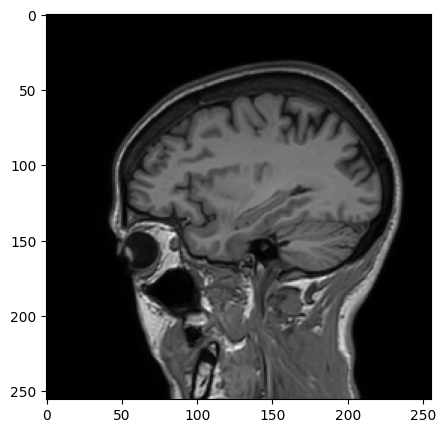

In [11]:
# Ejemplo de una imágen de alta resolución
plt.figure(figsize=(5,5))
plt.imshow(high_img_mri[1000], cmap='gray')

## 4. Get the Low Resolution MRI Images

In [12]:
def low_res_image(images, factor):
    low_res_image_result = []
    for image in images:
        downsampled_size = (int(image.shape[1]*factor), int(image.shape[0]*factor))
        image_downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_AREA)
        image_upsampled = cv2.resize(image_downsampled, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
        low_res_image_result.append(image_upsampled)
    return np.stack(low_res_image_result, axis=0)

In [13]:
factor_res = 0.5 # Factor de reducción de resolución
low_img_mri = low_res_image(high_img_mri, factor_res)
print(np.min(low_img_mri), np.max(low_img_mri))
print("Forma del tensor de imágenes de baja resolución para entrenamiento:", low_img_mri.shape)

0.0 0.82849914
Forma del tensor de imágenes de baja resolución para entrenamiento: (31474, 256, 256)


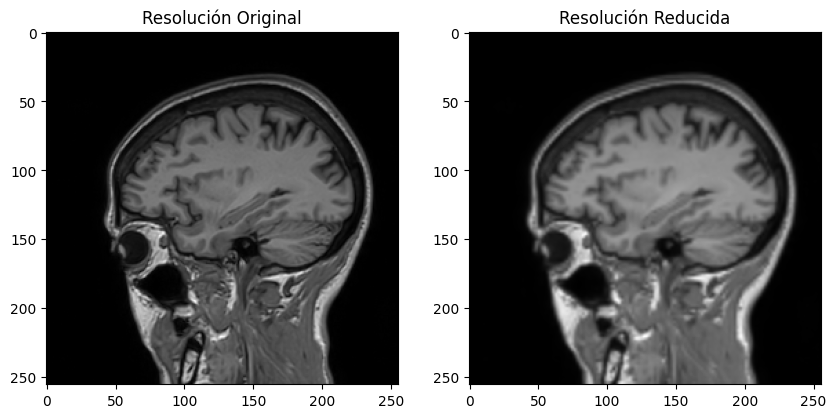

In [15]:
# Visualización para comparar la resolución original con la resolución reducida
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(high_img_mri[1000], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(low_img_mri[1000], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

## 5. Reshaping the Data

In [19]:
SIZE = 256
# Calcular índices de división de datos
total_img = len(high_img_mri)
train_limit = int(total_img * 0.8)
validation_limit = train_limit + int(total_img * 0.1)

In [20]:
# Función para modificar la forma del tensor
def add_channel_dimension(images):
    return np.reshape(images, (len(images), SIZE, SIZE, 1))

In [21]:
# Datos de entrenamiento
train_high_mri = high_img_mri[:train_limit]
train_low_mri = low_img_mri[:train_limit]
train_high_mri = add_channel_dimension(train_high_mri)
train_low_mri = add_channel_dimension(train_low_mri)

In [22]:
# Datos de validación
validation_high_mri = high_img_mri[train_limit:validation_limit]
validation_low_mri = low_img_mri[train_limit:validation_limit]
validation_high_mri = add_channel_dimension(validation_high_mri)
validation_low_mri = add_channel_dimension(validation_low_mri)

In [23]:
# Datos de prueba
test_high_mri = high_img_mri[validation_limit:]
test_low_mri = low_img_mri[validation_limit:]
test_high_mri= add_channel_dimension(test_high_mri)
test_low_mri = add_channel_dimension(test_low_mri)

In [28]:
print("Shape of training high mri:", train_high_mri.shape)
print("Shape of validation high mri:", validation_high_mri.shape)
print("Shape of test high mri:", test_high_mri.shape)

Shape of training high mri: (25179, 256, 256, 1)
Shape of validation high mri: (3147, 256, 256, 1)
Shape of test high mri: (3148, 256, 256, 1)


In [29]:
print("Shape of training low mri:", train_low_mri.shape)
print("Shape of validation low mri:", validation_low_mri.shape)
print("Shape of test low mri:", test_low_mri.shape)

Shape of training low mri: (25179, 256, 256, 1)
Shape of validation low mri: (3147, 256, 256, 1)
Shape of test low mri: (3148, 256, 256, 1)


## 6. Saving the Data

In [27]:
np.save('train_high_mri.npy', train_high_mri)
np.save('validation_high_mri.npy', validation_high_mri)
np.save('test_high_mri.npy', test_high_mri)
np.save('train_low_mri.npy', train_low_mri)
np.save('validation_low_mri.npy', validation_low_mri)
np.save('test_low_mri.npy', test_low_mri)